In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [76]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.4.0
Torchvision version 0.19.0
Numpy version 1.26.4
Pandas version 2.2.2


In [77]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [78]:
dataset = PlayingCardDataset(
    data_dir='./PlantVillage'
)

In [79]:
len(dataset)

16011

In [102]:
image, label = dataset[6000]
print(label)
image

5


tensor([[[0.5373, 0.5686, 0.5647,  ..., 0.6706, 0.6745, 0.6902],
         [0.5412, 0.5569, 0.5686,  ..., 0.6706, 0.6902, 0.6980],
         [0.5020, 0.5451, 0.5686,  ..., 0.6863, 0.7098, 0.6902],
         ...,
         [0.4627, 0.4824, 0.4745,  ..., 0.5569, 0.5490, 0.5608],
         [0.4549, 0.4706, 0.4784,  ..., 0.5412, 0.5490, 0.5843],
         [0.4706, 0.4745, 0.4863,  ..., 0.5451, 0.5451, 0.5569]],

        [[0.4941, 0.5255, 0.5216,  ..., 0.6471, 0.6510, 0.6667],
         [0.4980, 0.5137, 0.5255,  ..., 0.6471, 0.6667, 0.6745],
         [0.4588, 0.5020, 0.5255,  ..., 0.6627, 0.6863, 0.6667],
         ...,
         [0.4353, 0.4549, 0.4471,  ..., 0.5333, 0.5255, 0.5373],
         [0.4275, 0.4431, 0.4510,  ..., 0.5176, 0.5255, 0.5608],
         [0.4431, 0.4471, 0.4588,  ..., 0.5216, 0.5216, 0.5333]],

        [[0.5098, 0.5412, 0.5373,  ..., 0.6549, 0.6588, 0.6745],
         [0.5137, 0.5294, 0.5412,  ..., 0.6549, 0.6745, 0.6824],
         [0.4745, 0.5176, 0.5412,  ..., 0.6706, 0.6941, 0.

In [81]:
# Get a dictionary associating target values with folder names
data_dir = './PlantVillage'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Tomato_Bacterial_spot', 1: 'Tomato_Early_blight', 2: 'Tomato_Late_blight', 3: 'Tomato_Leaf_Mold', 4: 'Tomato_Septoria_leaf_spot', 5: 'Tomato_Spider_mites_Two_spotted_spider_mite', 6: 'Tomato__Target_Spot', 7: 'Tomato__Tomato_YellowLeaf__Curl_Virus', 8: 'Tomato__Tomato_mosaic_virus', 9: 'Tomato_healthy'}


In [82]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = './PlantVillage'
dataset = PlayingCardDataset(data_dir, transform)

In [83]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [84]:
# iterate over dataset
for image, label in dataset:
    break

In [85]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [86]:
for images, labels in dataloader:
    break

In [87]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [88]:
labels

tensor([7, 7, 9, 7, 7, 5, 7, 3, 7, 0, 0, 4, 0, 2, 5, 5, 2, 6, 4, 6, 4, 0, 4, 2,
        7, 2, 4, 2, 0, 7, 2, 7])

# Pytorch Model

In [89]:
class SimpleTomatoLeafClassifer(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleTomatoLeafClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [90]:
model = SimpleTomatoLeafClassifer(num_classes=10)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [91]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 10])

# The training loop

In [92]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 10]) torch.Size([32])


Setup Datasets

In [94]:
from sklearn.model_selection import train_test_split

# Define the size of each split
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Get all indices
total_size = len(dataset)
indices = list(range(total_size))

# Split indices for training, validation, and test
train_indices, temp_indices = train_test_split(indices, test_size=(1 - train_size), random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=(test_size / (val_size + test_size)), random_state=42)


In [95]:
from torch.utils.data import DataLoader, Subset
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [96]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Simple Training Loop

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [97]:
# Simple training loop
num_epochs = 8
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleTomatoLeafClassifer(num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 1/8 - Train loss: 0.29844868453848616, Validation loss: 0.10376588856774632


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 2/8 - Train loss: 0.10016928711582643, Validation loss: 0.07424810403832313


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 3/8 - Train loss: 0.066215891717463, Validation loss: 0.139491268167768


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 4/8 - Train loss: 0.060508102967293385, Validation loss: 0.08136463406635942


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 5/8 - Train loss: 0.05682316364224678, Validation loss: 0.06832048249886


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 6/8 - Train loss: 0.05540156650926279, Validation loss: 0.0432805957464346


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 7/8 - Train loss: 0.04418619270431895, Validation loss: 0.06078683813236334


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 8/8 - Train loss: 0.0350005448686976, Validation loss: 0.07086304427298287


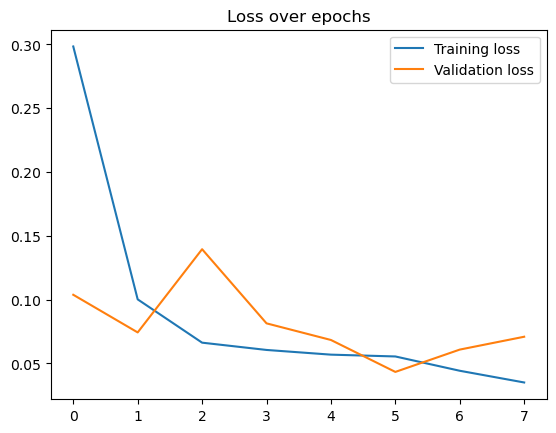

In [98]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [121]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")


Test Accuracy: 97.81386633354154%


In [104]:
# Save the model
torch.save(model.state_dict(), 'my_model_torch.pth')

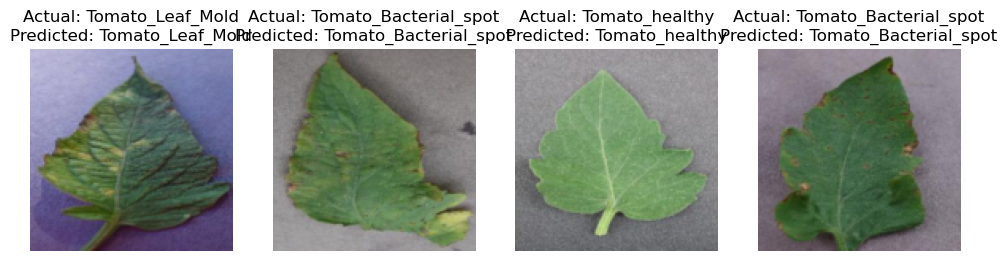

In [71]:
# Display 4 images from the test set and their predicted labels
def show_images(images, labels, predictions, class_names):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).cpu().numpy()
        label = class_names[labels[i]]
        pred = class_names[predictions[i]]
        ax.imshow(image)
        ax.set_title(f"Actual: {label}\nPredicted: {pred}")
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Show the first 4 images in the batch
show_images(images[:4], labels[:4], predictions[:4], dataset.classes)


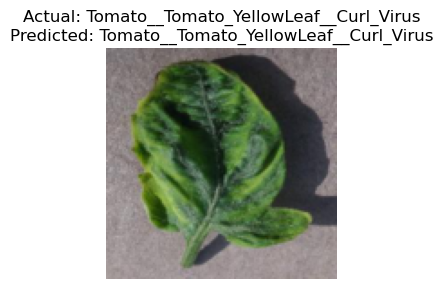

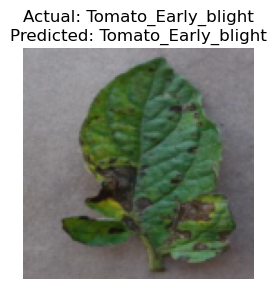

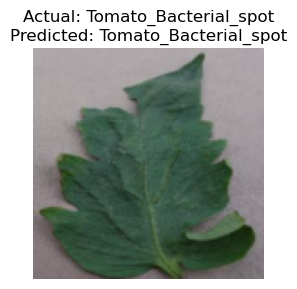

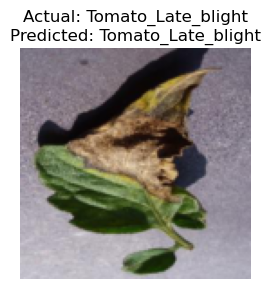

In [128]:
def show_images_vertically(images, labels, predictions, class_names):
    for i in range(4):
        plt.figure(figsize=(3, 3))
        image = images[i].permute(1, 2, 0).cpu().numpy()
        label = class_names[labels[i]]
        pred = class_names[predictions[i]]
        plt.imshow(image)
        plt.title(f"Actual: {label}\nPredicted: {pred}")
        plt.axis('off')
        plt.show()

# Get a batch of images and labels
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Show the first 4 images in separate plots vertically
show_images_vertically(images[:4], labels[:4], predictions[:4], dataset.classes)


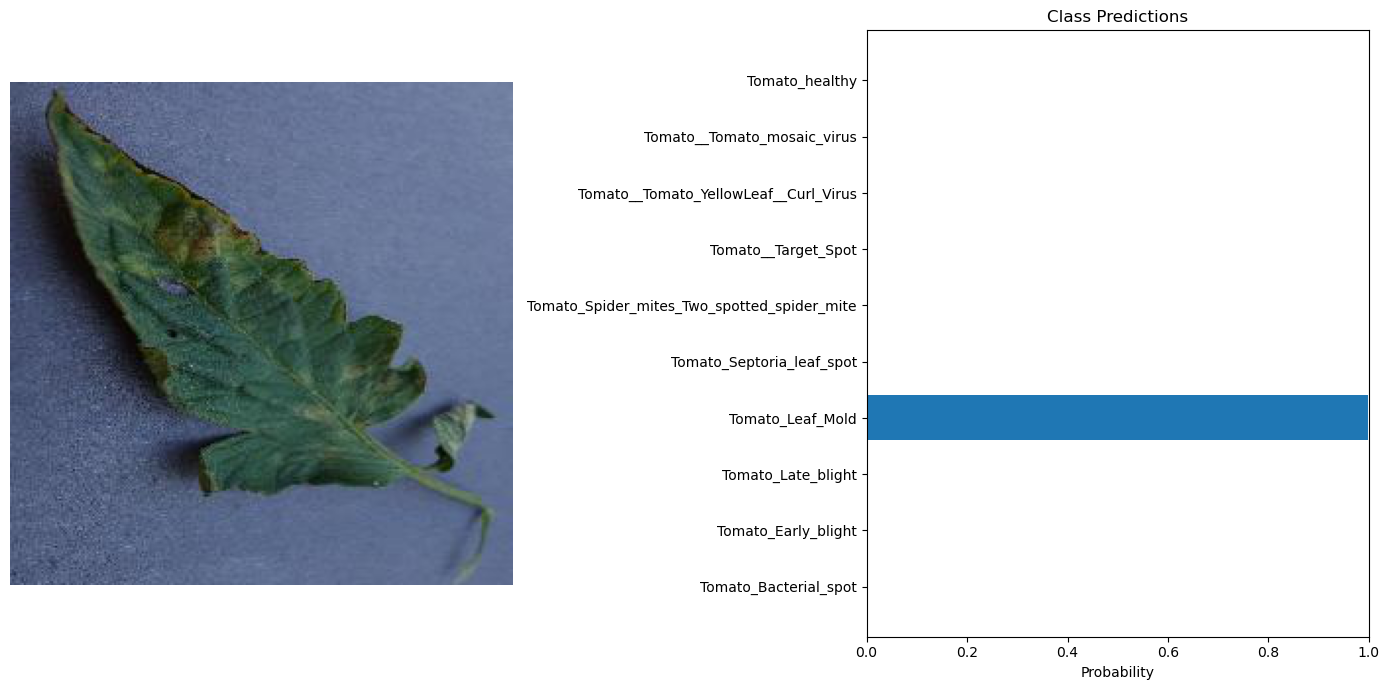

In [127]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "./PlantVillage/Tomato_Leaf_Mold/fe60a756-1145-4ed4-9496-af5f387f0222___Crnl_L.Mold 8965.JPG"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

# Loading the saved model

In [118]:
# Load the model
model = SimpleTomatoLeafClassifer()
model.load_state_dict(torch.load('my_model.pth'))
model.eval()  # Set the model to evaluation mode


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34660\3675963890.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('my_model.pth'))


SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (c

In [119]:
# Assuming you are using a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to GPU
model = model.to(device)

# Move the input data to GPU
images = images.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
